<a href="https://colab.research.google.com/github/fumingqian1123/427-Timing-is-Everything/blob/main/stat527_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.feature_selection import RFE
import os
from sklearn.metrics import log_loss
from itertools import combinations
import pymc as pm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

In [ ]:
from google.colab import drive
from sklearn.metrics import roc_curve, auc
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/stat527')

Mounted at /content/drive


In [ ]:
# data intro
data = pd.read_csv('diabetes.csv')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


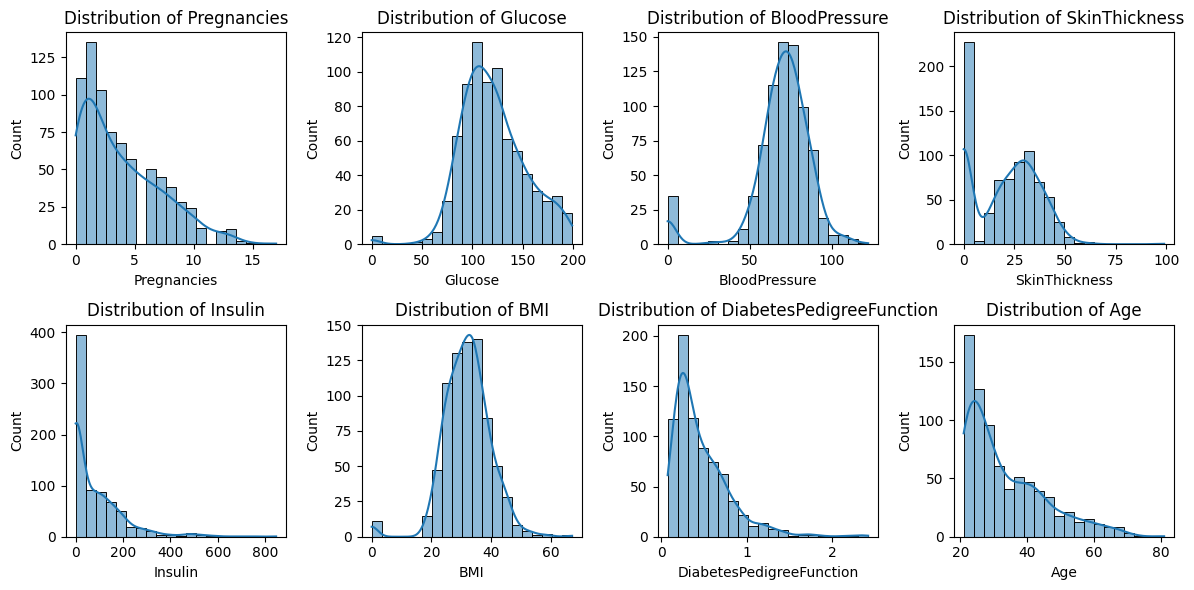

In [ ]:

plt.figure(figsize=(12, 6))
for i, col in enumerate(data.columns[:-1], 1):
    plt.subplot(2, 4, i)
    sns.histplot(data[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [ ]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_counts = (data[columns_with_zeros] == 0).sum()

zero_ratios = (data[columns_with_zeros] == 0).mean() * 100

print("zero counts：")
print(zero_counts)

print("\nzero ratios：")
print(zero_ratios)

zero counts：
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

zero ratios：
Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64


In [ ]:
columns_with_zeros_repalcebymedian = ['Glucose', 'BloodPressure',  'BMI']
data[columns_with_zeros_repalcebymedian] = data[columns_with_zeros_repalcebymedian].replace(0, np.nan)

missing_values_summary = data.isnull().mean() * 100
print("missing value ratios：")
print(missing_values_summary)

for column in columns_with_zeros:
    data[column].fillna(data[column].median(), inplace=True)

print(data.describe())

missing value ratios：
Pregnancies                 0.000000
Glucose                     0.651042
BloodPressure               4.557292
SkinThickness               0.000000
Insulin                     0.000000
BMI                         1.432292
DiabetesPedigreeFunction    0.000000
Age                         0.000000
Outcome                     0.000000
dtype: float64
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      20.536458   79.799479   
std       3.369578   30.438286      12.096642      15.952218  115.244002   
min       0.000000   44.000000      24.000000       0.000000    0.000000   
25%       1.000000   99.750000      64.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  19

<ipython-input-6-9df94ab3a77f>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)


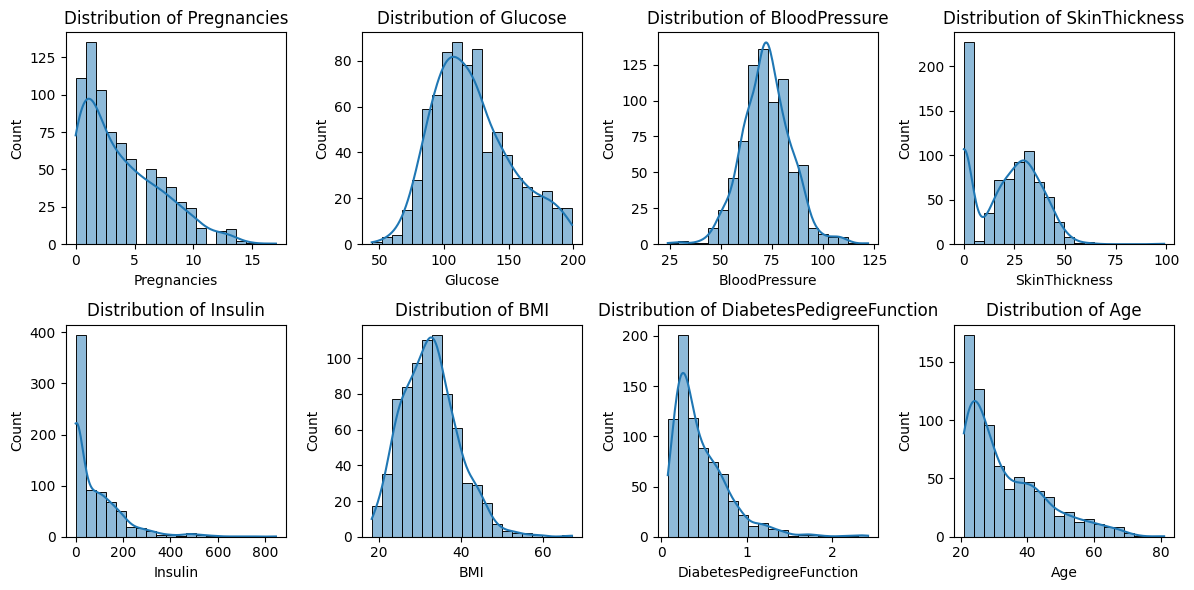

In [ ]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(data.columns[:-1], 1):
    plt.subplot(2, 4, i)
    sns.histplot(data[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

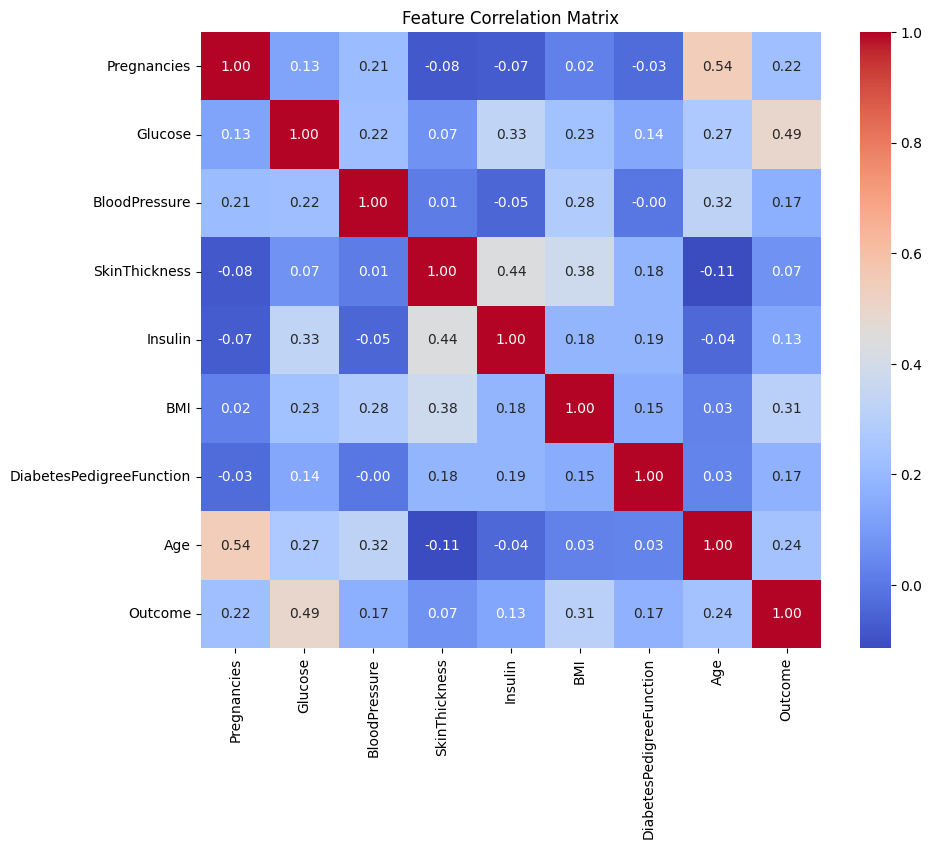

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
n_features = X_train.shape[1]

traces = []
ppcs = []

for i in range(1, n_features + 1):
    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        betas = pm.Normal('betas', mu=0, sigma=10, shape=i)
        sigma = pm.HalfNormal('sigma', sigma=1)
        p = pm.math.sigmoid(alpha + pm.math.dot(X_train[:, :i], betas))

        Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y_train)
        trace = pm.sample(2000, return_inferencedata=False)
        traces.append(trace)
        ppc = pm.sample_posterior_predictive(trace, var_names=['alpha', 'betas'])
        ppcs.append(ppc)

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [ ]:
log_likelihoods = []
for i, ppc in enumerate(ppcs, start=1):
    alpha = np.where(ppc.posterior_predictive['alpha'] <= 0, 1e-10, ppc.posterior_predictive['alpha'])

    log_likelihood = np.sum(np.log(alpha))
    log_likelihoods.append(log_likelihood)
    print(f"model {i}'s log likelihood is': {log_likelihood}")


模型 1（使用前 1 个特征）的对数似然为: -42217.312752836115
模型 2（使用前 2 个特征）的对数似然为: -42462.28195966735
模型 3（使用前 3 个特征）的对数似然为: -42237.066415037625
模型 4（使用前 4 个特征）的对数似然为: -42368.11347405686
模型 5（使用前 5 个特征）的对数似然为: -43497.530386603365
模型 6（使用前 6 个特征）的对数似然为: -43081.897979202564
模型 7（使用前 7 个特征）的对数似然为: -41713.88224967722
模型 8（使用前 8 个特征）的对数似然为: -43798.27692379066


In [ ]:
bayes_factors = []

for i in range(len(log_likelihoods) - 1):
    log_diff = log_likelihoods[-1] - log_likelihoods[i]
    bayes_factor = np.exp(log_diff)

    bayes_factors.append((len(log_likelihoods), i + 1, log_diff, bayes_factor))
    print(f"model {len(log_likelihoods)} and model {i + 1} loglikihood difference {log_diff:.2f}，Bayes factor is {bayes_factor:.2f}")

模型 8 与 模型 1 的对数似然差异为 -1580.96，Bayes 因子为 0.00
模型 8 与 模型 2 的对数似然差异为 -1335.99，Bayes 因子为 0.00
模型 8 与 模型 3 的对数似然差异为 -1561.21，Bayes 因子为 0.00
模型 8 与 模型 4 的对数似然差异为 -1430.16，Bayes 因子为 0.00
模型 8 与 模型 5 的对数似然差异为 -300.75，Bayes 因子为 0.00
模型 8 与 模型 6 的对数似然差异为 -716.38，Bayes 因子为 0.00
模型 8 与 模型 7 的对数似然差异为 -2084.39，Bayes 因子为 0.00


In [ ]:
model_3_ll = log_likelihoods[2]
model_7_ll = log_likelihoods[6]
log_diff = model_7_ll - model_3_ll
bayes_factor = np.exp(log_diff)
print(f"model 7 与 model 3 loglikihood differnce is {log_diff:.2f}，Bayes factor is {bayes_factor:.2f}")

model_4_ll = log_likelihoods[3]
log_diff = model_7_ll - model_4_ll
bayes_factor = np.exp(log_diff)
print(f"model 7 与 model 4 loglikihood differnce is {log_diff:.2f}，Bayes factor is {bayes_factor:.2f}")

model_6_ll = log_likelihoods[5]
log_diff = model_7_ll - model_6_ll
bayes_factor = np.exp(log_diff)
print(f"model 7 与 model 6 loglikihood differnce is {log_diff:.2f}，Bayes factor is {bayes_factor:.2f}")

模型 7 与 模型 3 的对数似然差异为 523.18，Bayes 因子为 164435671127292601081628189529768611690482535099152619584300760151477688362094577184198671158356761159374344652254959058928816791647969676105518005294481052636073392693508907248201538897103111032435417412748624457021430115074048.00
模型 7 与 模型 4 的对数似然差异为 654.23，Bayes 因子为 134589331772264865985307222484399509219696415195449911065965264809747023811552655569913695923826580826800422195936147983474729282231511015926005413467639874973356386679653816622447807667759833295850766302062400748490850164148068389499755525426049843471228255636574583758904875131338752.00
模型 7 与 模型 6 的对数似然差异为 1368.02，Bayes 因子为 inf


<ipython-input-13-3b57ee35ab51>:14: RuntimeWarning: overflow encountered in exp
  bayes_factor = np.exp(log_diff)


In [ ]:

selected_features = range(7)

X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

log_reg = LogisticRegression()

log_reg.fit(X_train_selected, y_train)

y_pred_bay = log_reg.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred_bay)
print(f"Model accuracy with the first 7 features: {accuracy:.4f}")

Model accuracy with the first 7 features: 0.7792


In [ ]:
lasso = LassoCV(cv=5).fit(X_train, y_train)
lasso_selected_features = np.where(lasso.coef_ != 0)[0]
X_train_lasso = X_train[:, lasso_selected_features]
X_test_lasso = X_test[:, lasso_selected_features]

initial_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
initial_coef = np.abs(initial_model.coef_).flatten()
weights = 1 / (initial_coef + 1e-5)
adaptive_lasso = LassoCV(cv=5).fit(X_train * weights, y_train)
adaptive_selected_features = np.where(adaptive_lasso.coef_ != 0)[0]
X_train_adaptive_lasso = X_train[:, adaptive_selected_features]
X_test_adaptive_lasso = X_test[:, adaptive_selected_features]


In [ ]:
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=5)
rfe.fit(X_train, y_train)
rfe_selected_features = np.where(rfe.support_)[0]
X_train_rfe = X_train[:, rfe_selected_features]
X_test_rfe = X_test[:, rfe_selected_features]


In [ ]:
lasso_log_reg = LogisticRegression(max_iter=1000).fit(X_train_lasso, y_train)
y_pred_lasso = lasso_log_reg.predict(X_test_lasso)

adaptive_lasso_log_reg = LogisticRegression(max_iter=1000).fit(X_train_adaptive_lasso, y_train)
y_pred_adaptive_lasso = adaptive_lasso_log_reg.predict(X_test_adaptive_lasso)

rfe_log_reg = LogisticRegression(max_iter=1000).fit(X_train_rfe, y_train)
y_pred_rfe = rfe_log_reg.predict(X_test_rfe)


In [ ]:
def evaluate_model(y_true, y_pred, method_name):
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    type_i_error = cm[0][1] / (cm[0][1] + cm[0][0])
    type_ii_error = cm[1][0] / (cm[1][0] + cm[1][1])

    print(f"Results for {method_name}:")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"Type I Error (False Positive Rate): {type_i_error}")
    print(f"Type II Error (False Negative Rate): {type_ii_error}")
    print("\n")

evaluate_model(y_test, y_pred_lasso, "LASSO")

evaluate_model(y_test, y_pred_adaptive_lasso, "Adaptive LASSO")

evaluate_model(y_test, y_pred_rfe, "RFE")

evaluate_model(y_test, y_pred_bay, "Bayes")


Results for LASSO:
Confusion Matrix:
[[83 16]
 [19 36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        99
           1       0.69      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154

Type I Error (False Positive Rate): 0.16161616161616163
Type II Error (False Negative Rate): 0.34545454545454546


Results for Adaptive LASSO:
Confusion Matrix:
[[83 16]
 [19 36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        99
           1       0.69      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154

Type I Error (False Positive Rate): 0.16161616161616163
Type II 

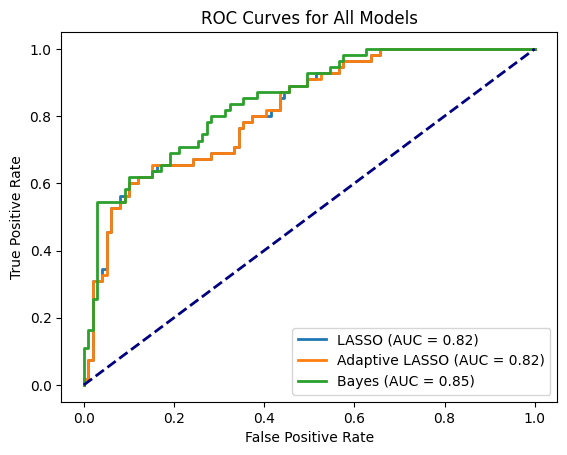

In [ ]:
def plot_all_roc_curves(y_true, y_probs_dict):
    plt.figure()
    for method_name, y_prob in y_probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{method_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.show()

y_prob_lasso = lasso_log_reg.predict_proba(X_test_lasso)[:, 1]
y_prob_adaptive_lasso = adaptive_lasso_log_reg.predict_proba(X_test_adaptive_lasso)[:, 1]
y_prob_rfe = rfe_log_reg.predict_proba(X_test_rfe)[:, 1]
y_prob_bay = log_reg.predict_proba(X_test_selected)[:, 1]

y_probs_dict = {
    "LASSO": y_prob_lasso,
    "Adaptive LASSO": y_prob_adaptive_lasso,
    # "RFE": y_prob_rfe,
    "Bayes": y_prob_bay
}
plot_all_roc_curves(y_test, y_probs_dict)